# Numpy-имплементация многослойной нейронной сети

## Цель работы 

реализовать нейронную сеть и обучить ее с помощью метода обратного распространения ошибки.


## Задачи

* реализовать нейронную сеть на основе numpy

* обучить созданную нейронную сеть

In [1]:
import numpy as np

Сначала определим базовый класс Layer с основными методами .forward() и .backward().

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

# 1. ReLU слой

In [3]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.maximum(0, input)  # applying ReLU elementwise
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0  # creating a mask for positive values
        return grad_output * relu_grad_mask


Теперь этот код применяет функцию ReLU к каждому элементу входных данных и вычисляет обратное распространение градиента для ReLU слоя.

In [4]:
# some tests
from util import eval_numerical_gradient
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

# Полносвязный слой

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output_units]
        """
        output = np.dot(input, self.weights) + self.biases
        return output
    
    def backward(self, input, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


## Тестирование полносвязного слоя

In [6]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [7]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [8]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


# Функция потерь 

In [9]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [10]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

# Итоговая нейросеть

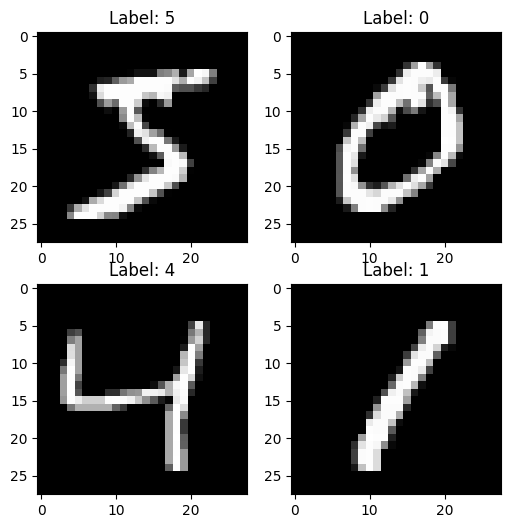

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [12]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

In [13]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
    
    assert len(activations) == len(network)
    return activations


In [14]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
        
    # Propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    grad_output = loss_grad
    for layer, input in zip(reversed(network), reversed(layer_inputs[:-1])):
        grad_output = layer.backward(input, grad_output)
        
    return np.mean(loss)


In [15]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [16]:
from IPython.display import clear_output
train_log = []
val_log = []

In [17]:
def predict(network, X):
    """
    Использует сеть для предсказания наиболее вероятного класса для каждого примера.
    """
    logits = forward(network, X)[-1]
    return np.argmax(logits, axis=-1)


Epoch 14
Train accuracy: 0.98894
Val accuracy: 0.9698


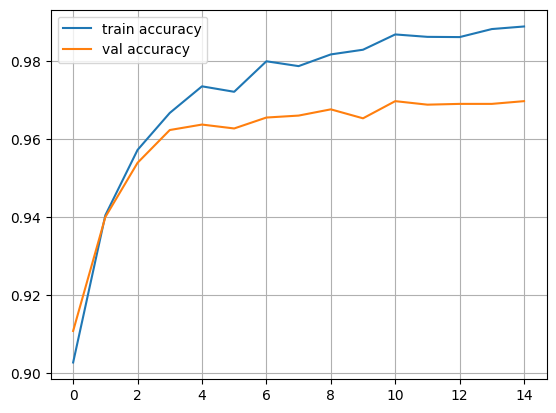

In [18]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

# Нейросеть для извлечения представлений

In [19]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]


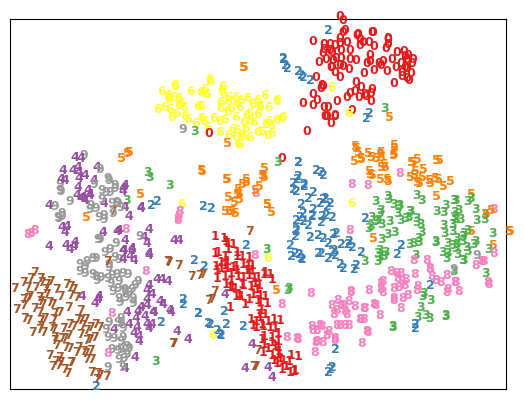

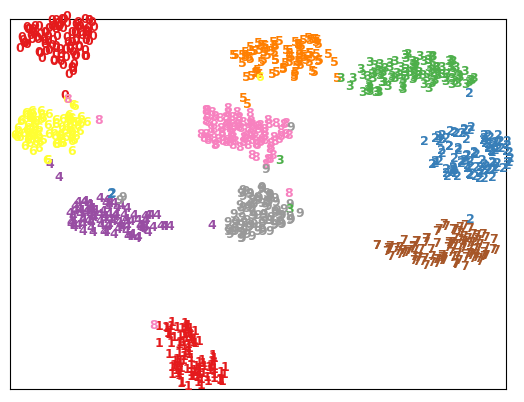

In [20]:
from util import plot_embedding
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]
x_original_tsne = TSNE(n_components=2).fit_transform(X_train[subset_ids])
x_learnt_tsne = TSNE(n_components=2).fit_transform(train_hidden_representations[subset_ids])
plot_embedding(x_original_tsne, y_train[subset_ids])
plot_embedding(x_learnt_tsne, y_train[subset_ids])


простейшая логистическая регресия, предсказывающая четность изображенной цифры, используя в качестве вектора признаков:

* исходные 784-мерные представления

* обученные представления

In [21]:
new_y_train = y_train % 2
new_y_test = y_test % 2

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(solver="lbfgs")
lr.fit(X_train, new_y_train)
y_pred_original = lr.predict(X_test)
accuracy_original = accuracy_score(new_y_test, y_pred_original)
print("Accuracy using original 784-dimensional representations:", accuracy_original)

# Обучение логистической регрессии на обученных представлениях
lr_learnt = LogisticRegression(solver="lbfgs")
lr_learnt.fit(train_hidden_representations, new_y_train)
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]
y_pred_learnt = lr_learnt.predict(test_hidden_representations)
accuracy_learnt = accuracy_score(new_y_test, y_pred_learnt)
print("Accuracy using learnt representations:", accuracy_learnt)
if accuracy_learnt > accuracy_original:
    print("Learnt representations are more universal.")
else:
    print("Original 784-dimensional representations are more universal.")

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy using original 784-dimensional representations: 0.9021
Accuracy using learnt representations: 0.9573
Learnt representations are more universal.


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Контрольные вопросы

1. **Биологический и искусственный нейрон**:
   - **Биологический нейрон**: Является основным строительным блоком нервной системы живых организмов. Он состоит из тела клетки, дендритов (входные волокна), аксона (выходное волокно), и синапсов (соединения с другими нейронами). Биологические нейроны обрабатывают и передают электрические и химические сигналы между клетками.
   - **Искусственный нейрон (нейрон в искусственной нейронной сети)**: Это математическая модель, созданная для имитации работы биологических нейронов. Искусственный нейрон принимает входные сигналы, взвешивает их и передает результат через функцию активации для получения выходного сигнала. Он является основным строительным блоком искусственных нейронных сетей.

2. **Основные функции активации нейронов**:
   - **Сигмоидальная функция активации**: Преобразует взвешенную сумму входов в диапазон значений между 0 и 1. Применяется в задачах бинарной классификации.
   - **Гиперболический тангенс**: Преобразует взвешенную сумму входов в диапазон значений между -1 и 1. Похож на сигмоидальную функцию активации, но имеет более высокий градиент и более быстро насыщается.
   - **ReLU (Rectified Linear Unit)**: Преобразует взвешенную сумму входов, оставляя положительные значения без изменений и обнуляя отрицательные. Является одной из наиболее популярных функций активации из-за своей простоты и эффективности.
   - **Softmax**: Преобразует взвешенную сумму входов в вероятности для каждого класса в задаче многоклассовой классификации.

3. **Преимущества нейронных сетей**:
   - **Способность к автоматическому извлечению признаков**: Нейронные сети могут автоматически извлекать признаки из данных, что упрощает процесс обучения без необходимости ручного определения признаков.
   - **Гибкость и адаптивность**: Нейронные сети могут быть применены к широкому спектру задач, включая классификацию, регрессию, обработку изображений, обработку естественного языка и т.д.
   - **Высокая производительность**: В некоторых задачах нейронные сети могут превосходить традиционные методы машинного обучения по качеству результатов.

4. **Классификации нейронных сетей, области применения и решаемые задачи**:
   - **По архитектуре**: Различают полносвязные нейронные сети, сверточные нейронные сети (CNN), рекуррентные нейронные сети (RNN), глубокие нейронные сети (DNN), и т.д.
   - **Области применения**: Нейронные сети применяются в различных областях, включая компьютерное зрение, обработку естественного языка, медицину, финансы, рекомендательные системы, игры и др.
   - **Решаемые задачи**: Нейронные сети могут решать задачи классификации, регрессии, кластеризации, генерации контента, детекции объектов, сегментации изображений и многое другое.

5. **Основные направления развития нейрокомпьютинга**:
   - **Глубокое обучение**: Исследование и разработка алгоритмов и моделей глубокого обучения для решения сложных задач машинного обучения.
   - **Обучение с подкреплением**: Изучение методов обучения, в которых агент обучается взаимодействием с окружающей средой и получением обратной

 связи в виде награды.
   - **Обработка последовательных данных**: Развитие методов обработки последовательных данных, таких как временные ряды, тексты, аудио и видео.
   - **Интеграция с другими технологиями**: Исследование и разработка методов интеграции нейронных сетей с другими технологиями, такими как робототехника, автономные системы, IoT и др.